# 🧪 Molecular Dynamics (MD) Analysis of PIA-KRASv2-Nb

This Google Colab notebook is designed to analyze molecular dynamics simulations of a candidate nanobody against KRAS.  
The workflow is divided into several cells, each with a specific function:

---

## 📌 Analysis Workflow

1. **Library Installation (Cell 1)** - Automatically installs the necessary dependencies: `MDTraj`, `Pandas`, `Matplotlib`.  
   - These libraries allow loading, processing, and visualizing molecular dynamics trajectories.

2. **Simulation File Upload (Cell 2)** - Allows uploading the **structure** file (`protein_system_CORRECTED.pdb`) and the **trajectory** file (`trajectory.dcd`).  
   - These files are generated by simulation engines such as AMBER, GROMACS, or NAMD.

3. **RMSD Analysis (Cell 3)** - Calculates the **Root Mean Square Deviation (RMSD)** for:
     - The nanobody scaffold (Framework).  
     - The binding loops (CDRs).  
   - Exports the values to a `.csv` file and generates a conformational stability plot over the simulation time.

4. **Contact Network Analysis (Cell 4)** - Detects and quantifies the number of **interacting residue pairs (< 4 Å)** between the nanobody and KRAS throughout the trajectory.  
   - Produces a `.csv` file detailing the evolution of contacts and a plot comparing it with the static AlphaFold prediction.

5. **Statistical Trend Analysis (Cell 5)** - Applies a **linear regression** to the number of residue-residue contacts over time.  
   - Reports whether there is a statistically significant trend (p-value < 0.05) indicating an increase or decrease in interface stability.

---

## 📊 Expected Results
- **Downloadable `.csv` files** containing RMSD values and contact numbers.  
- **Conformational stability and contact plots** ready for inclusion in reports or publications.  
- **Key statistics (slope, p-value, R²)** to validate the robustness of the interaction.  

---

➡️ Overall, this notebook enables a quantitative evaluation of whether the Nanobody–KRAS complex remains stable during the molecular dynamics simulation and whether it exhibits structural robustness justifying its experimental validation.

In [1]:
# --- Cell 1: Install Analysis Libraries ---
print("Installing the necessary libraries for analysis (MDTraj, Pandas)...")
!pip install mdtraj pandas matplotlib &> /dev/null
print("Installation complete!")

Installing the necessary libraries for analysis (MDTraj, Pandas)...
Installation complete!


In [2]:
# --- Cell 2: Upload Simulation Files ---
from google.colab import files

print("Please select the STRUCTURE file (protein_system_CORRECTED.pdb)...")
files.upload()

print("\nNow, select the TRAJECTORY file (trajectory.dcd)...")
files.upload()

print("\nFiles uploaded successfully!")

Please select the STRUCTURE file (protein_system_CORRECTED.pdb)...



Now, select the TRAJECTORY file (trajectory.dcd)...



Files uploaded successfully!


--- Starting trajectory RMSD analysis ---

Loading structure and trajectory...
Trajectory loaded: 5000 frames.
Actual duration of the analyzed trajectory: 10.0 ns
Nanobody identified in Chain: 0, KRAS in Chain: 1

Aligning trajectory and calculating RMSD...
Calculations completed.

Creating file 'rmsd_analysis_10.0ns.csv'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export to CSV completed!

Generating RMSD analysis plot...


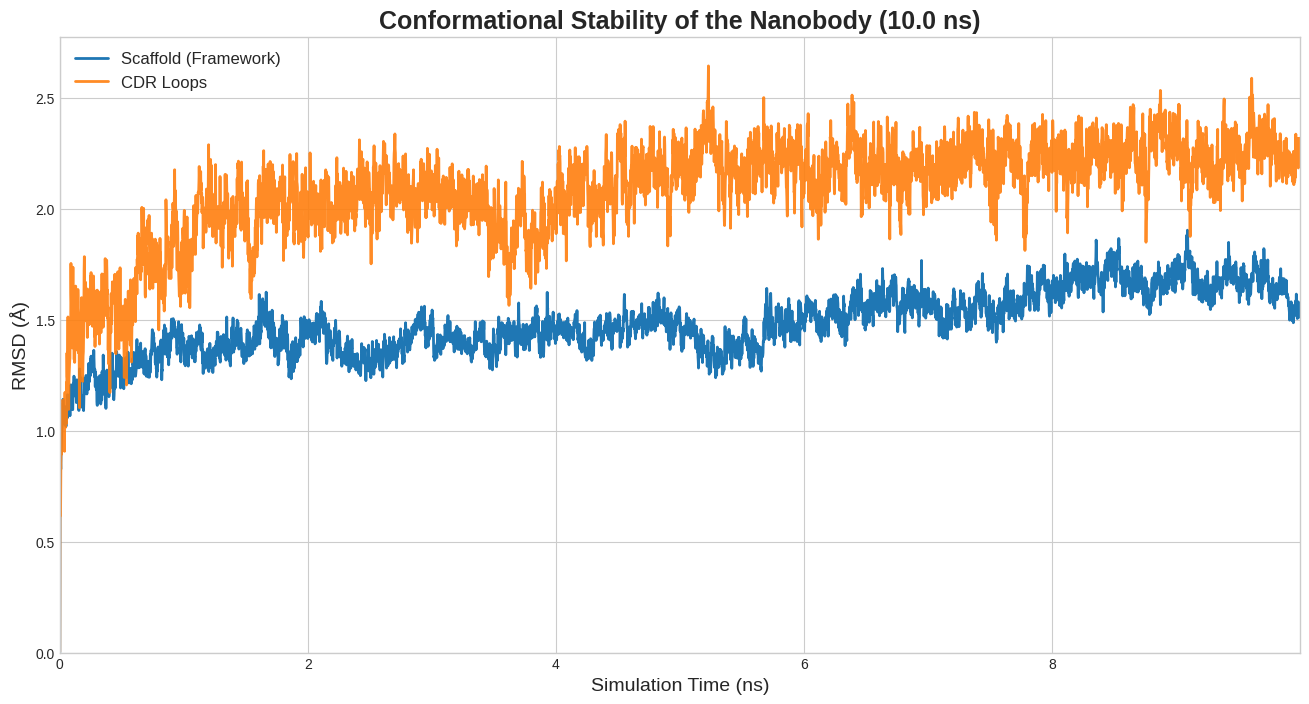

In [3]:
# --- Cell 3: RMSD Analysis for 10 ns Simulation ---

print("--- Starting trajectory RMSD analysis ---")

import mdtraj as md
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import files

# ==============================================================================
# >> CONTROL PANEL <<
# ==============================================================================
PDB_FILE = "protein_system_CORRECTED.pdb"
TRAJECTORY_FILE = "trajectory.dcd"
# REAL parameters of your simulation (to build the correct time axis)
TIMESTEP_FS = 2.0
REPORT_INTERVAL_STEPS = 1000
# ==============================================================================

if not os.path.exists(PDB_FILE) or not os.path.exists(TRAJECTORY_FILE):
    print(f"\nError! Files not found.")
else:
    print(f"\nLoading structure and trajectory...")
    traj = md.load(TRAJECTORY_FILE, top=PDB_FILE)
    print(f"Trajectory loaded: {traj.n_frames} frames.")

    # --- Manual and Robust Construction of the Time Axis ---
    TIME_PER_FRAME_PS = (TIMESTEP_FS * REPORT_INTERVAL_STEPS) / 1000.0
    time_ns = (np.arange(traj.n_frames) * TIME_PER_FRAME_PS) / 1000.0
    SIMULATION_TIME_NS = time_ns[-1]
    print(f"Actual duration of the analyzed trajectory: {SIMULATION_TIME_NS:.1f} ns")

    # --- Automatic chain diagnosis ---
    protein_chains = [chain for chain in traj.topology.chains if any(res.is_protein for res in chain.residues)]
    if len(protein_chains) < 2:
        raise SystemExit("Error: At least two protein chains were not found.")
    chain_lengths = [(chain.index, len([res for res in chain.residues if res.is_protein])) for chain in protein_chains]
    chain_lengths.sort(key=lambda x: x[1], reverse=True)
    nanobody_chain_id = chain_lengths[0][0]
    kras_chain_id = chain_lengths[1][0]
    print(f"Nanobody identified in Chain: {nanobody_chain_id}, KRAS in Chain: {kras_chain_id}")

    # --- Selections for RMSD ---
    fw_indices_str = f'protein and chainid {nanobody_chain_id} and (resid 0 to 25 or resid 33 to 49 or resid 58 to 94 or resid 103 to 112)'
    cdr_indices_str = f'protein and chainid {nanobody_chain_id} and (resid 26 to 32 or resid 50 to 57 or resid 95 to 102)'
    nanobody_framework_atoms = traj.topology.select(fw_indices_str)
    nanobody_cdr_atoms = traj.topology.select(cdr_indices_str)

    # --- RMSD Calculations ---
    print("\nAligning trajectory and calculating RMSD...")
    reference_indices = traj.topology.select(f'protein and chainid {kras_chain_id} and backbone')
    traj.superpose(traj, frame=0, atom_indices=reference_indices)

    rmsd_framework = md.rmsd(traj, traj, frame=0, atom_indices=nanobody_framework_atoms) * 10
    rmsd_cdrs = md.rmsd(traj, traj, frame=0, atom_indices=nanobody_cdr_atoms) * 10
    print("Calculations completed.")

    # --- Export to CSV (RMSD data only) ---
    OUTPUT_CSV_FILE = f"rmsd_analysis_{SIMULATION_TIME_NS:.1f}ns.csv"
    print(f"\nCreating file '{OUTPUT_CSV_FILE}'...")
    df = pd.DataFrame({
        'Time_ns': time_ns,
        'RMSD_Framework_A': rmsd_framework,
        'RMSD_CDRs_A': rmsd_cdrs
    })
    df.to_csv(OUTPUT_CSV_FILE, index=False, float_format='%.4f')
    files.download(OUTPUT_CSV_FILE)
    print(f"Export to CSV completed!")

    # --- RMSD Plot Generation ---
    print("\nGenerating RMSD analysis plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    plt.plot(df['Time_ns'], df['RMSD_Framework_A'], label='Scaffold (Framework)', linewidth=2)
    plt.plot(df['Time_ns'], df['RMSD_CDRs_A'], label='CDR Loops', linewidth=2, alpha=0.9)

    plt.title(f'Conformational Stability of the Nanobody ({SIMULATION_TIME_NS:.1f} ns)', fontsize=18, fontweight='bold')
    plt.xlabel('Simulation Time (ns)', fontsize=14)
    plt.ylabel('RMSD (Å)', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.ylim(bottom=0)
    plt.xlim(left=0, right=SIMULATION_TIME_NS)

    plt.savefig(f'rmsd_analysis_plot_{SIMULATION_TIME_NS:.1f}ns.png', dpi=300, bbox_inches='tight')
    plt.show()

Installing necessary libraries (MDTraj, Pandas)...
Libraries imported.

Loading structure and trajectory...
Trajectory loaded: 5000 frames.

Identifying epitope and nanobody residues by chain...
Analyzing 120 Nanobody residues (Chain 0).
Analyzing 10 KRAS Epitope residues (Chain 1).

Calculating the number of interacting residue pairs (optimized method)...
Calculation complete. Average number of contacts: 29.17

Creating and downloading the CSV data file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'contact_analysis_residue_level_10.0ns_CORRECTED.csv' downloaded.

Generating the contact network plot with the corrected time axis...


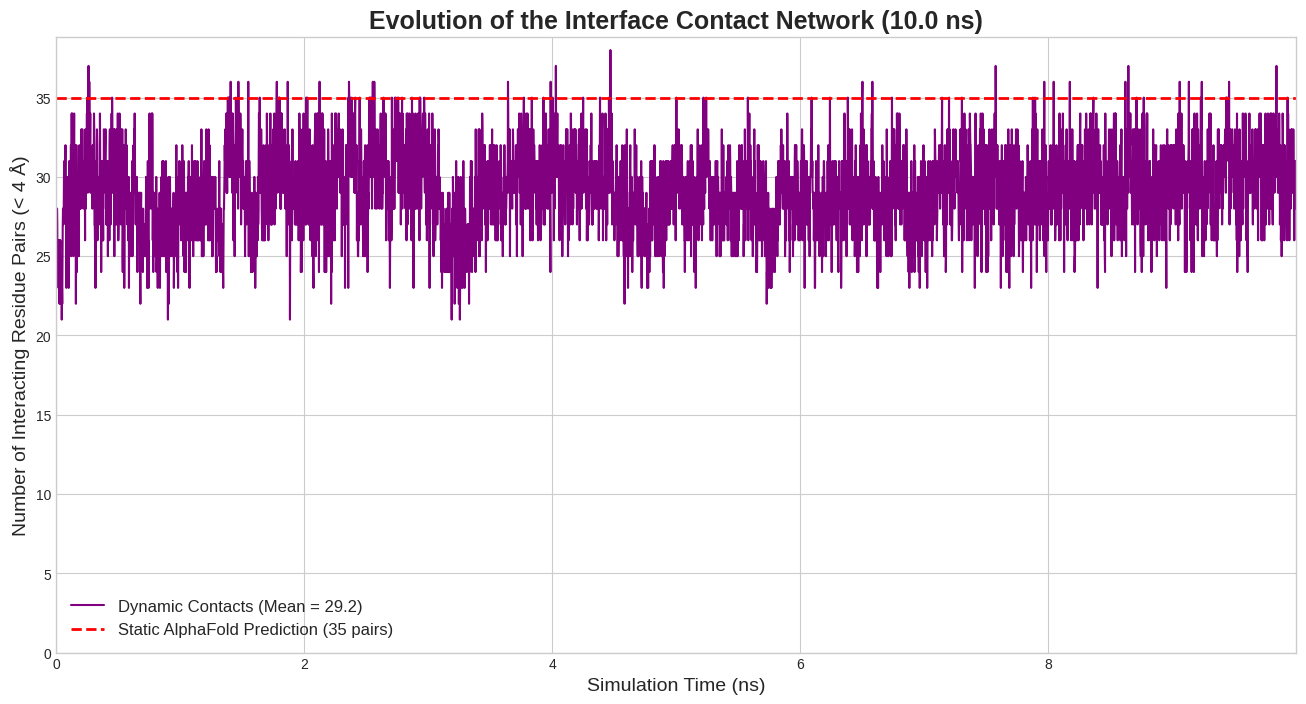

In [4]:
# --- Cell 4: Contact Network Analysis ---
# --- Step 1: Install and import necessary libraries ---
print("Installing necessary libraries (MDTraj, Pandas)...")
!pip install mdtraj pandas &> /dev/null
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from google.colab import files

print("Libraries imported.")

# --- Step 2: Define files and parameters ---
PDB_FILE = "protein_system_CORRECTED.pdb"
TRAJECTORY_FILE = "trajectory.dcd"
contact_cutoff_A = 4.0
contact_cutoff_nm = contact_cutoff_A / 10.0

# --- Step 3: Load the trajectory ---
if not os.path.exists(PDB_FILE) or not os.path.exists(TRAJECTORY_FILE):
    print(f"\nError! Files not found.")
else:
    print("\nLoading structure and trajectory...")
    traj = md.load(TRAJECTORY_FILE, top=PDB_FILE)
    topology = traj.topology
    print(f"Trajectory loaded: {traj.n_frames} frames.")

    # --- Step 4: SELECTION BASED ON REAL STRUCTURE (SEPARATE CHAINS) ---
    print("\nIdentifying epitope and nanobody residues by chain...")

    # Based on the diagnosis, Nanobody is Chain 0 and KRAS is Chain 1
    nanobody_residues = [res.index for res in topology.chain(0).residues if res.is_protein]
    kras_epitope_residues = [res.index for res in topology.chain(1).residues if res.is_protein]

    if not kras_epitope_residues or not nanobody_residues:
        print("\nSelection Error! No protein residues found in Chains 0 and 1.")
    else:
        print(f"Analyzing {len(nanobody_residues)} Nanobody residues (Chain 0).")
        print(f"Analyzing {len(kras_epitope_residues)} KRAS Epitope residues (Chain 1).")

        # --- Step 5: OPTIMIZED METHOD - Calculate contacts ---
        print("\nCalculating the number of interacting residue pairs (optimized method)...")

        residue_pairs_to_check = list(itertools.product(nanobody_residues, kras_epitope_residues))
        distances, pairs = md.compute_contacts(traj, contacts=residue_pairs_to_check, scheme='closest-heavy')
        contact_counts = np.sum(distances < contact_cutoff_nm, axis=1)
        average_contacts = np.mean(contact_counts)
        print(f"Calculation complete. Average number of contacts: {average_contacts:.2f}")

        # --- Step 6: Create and download the .csv file ---
        print("\nCreating and downloading the CSV data file...")

        # Constructing the correct time axis manually.
        time_ps = np.arange(traj.n_frames) * 2.0
        time_ns = time_ps / 1000.0
        # CHANGE 1: Calculate the actual duration for use in file names
        SIMULATION_TIME_NS = time_ns[-1]

        df = pd.DataFrame({'Time_ns': time_ns, 'NumberOfResidueContacts': contact_counts})
        # CHANGE 2: Update the CSV file name
        csv_filename = f'contact_analysis_residue_level_{SIMULATION_TIME_NS:.1f}ns_CORRECTED.csv'
        df.to_csv(csv_filename, index=False)
        files.download(csv_filename)
        print(f"File '{csv_filename}' downloaded.")

        # --- Step 7: Generate the plot ---
        print("\nGenerating the contact network plot with the corrected time axis...")
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(16, 8))

        plt.plot(time_ns, contact_counts, label=f'Dynamic Contacts (Mean = {average_contacts:.1f})', color='purple', linewidth=1.5)
        plt.axhline(y=35, color='red', linestyle='--', linewidth=2, label='Static AlphaFold Prediction (35 pairs)')

        # CHANGE 3: Update plot title and limits
        plt.title(f'Evolution of the Interface Contact Network ({SIMULATION_TIME_NS:.1f} ns)', fontsize=18, fontweight='bold')
        plt.xlabel('Simulation Time (ns)', fontsize=14)
        plt.ylabel('Number of Interacting Residue Pairs (< 4 Å)', fontsize=14)
        plt.legend(loc='lower left', fontsize=12) # Changed to 'lower left' (check original preference)

        plt.ylim(bottom=0)
        plt.xlim(left=0, right=SIMULATION_TIME_NS)

        plt.savefig(f'contact_network_plot_{SIMULATION_TIME_NS:.1f}ns_final.png', dpi=300, bbox_inches='tight')
        plt.show()

In [5]:
# --- Cell 5: Statistical Trend Analysis ---

print("--- Starting linear regression analysis ---")

import pandas as pd
from scipy import stats
import os

# Note: Ensure this matches the CSV filename generated in Cell 4
CSV_FILE = 'contact_analysis_residue_level_10.0ns_CORRECTED.csv'

if not os.path.exists(CSV_FILE):
    print(f"\nError! File '{CSV_FILE}' not found.")
    print("Please ensure you have run the previous cell that generates the CSV.")
else:
    try:
        # Load data from CSV file
        df = pd.read_csv(CSV_FILE)

        # Extract time and contact number columns
        time = df['Time_ns']
        contacts = df['NumberOfResidueContacts']

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(time, contacts)

        # --- Present results clearly ---
        print("\n=======================================================")
        print("    Trend Analysis Results")
        print("=======================================================")
        print(f"Trend Slope: {slope:.4f} contacts/ns")
        print(f"P-value (statistical significance): {p_value:.6f}")
        print(f"Correlation coefficient (R²): {r_value**2:.4f}")
        print("=======================================================")

        # --- Interpretation of results ---
        print("\nInterpretation:")

        if p_value < 0.05:
            print("✅ The p-value is less than 0.05, indicating the trend is STATISTICALLY SIGNIFICANT.")
            if slope > 0:
                print(f"   Your observation is CORRECT. There is a clear and measurable trend toward an INCREASE in the number of contacts.")
                print(f"   On average, the complex gains approximately {slope:.2f} interacting residue pairs per nanosecond.")
            elif slope < 0:
                print(f"   There is a clear and measurable trend toward a DECREASE in the number of contacts.")
                print(f"   On average, the complex loses approximately {abs(slope):.2f} interacting residue pairs per nanosecond.")
            else:
                print("   The slope is practically zero, so there is no significant upward or downward trend.")
        else:
            print("❌ The p-value is greater than 0.05, indicating the observed trend is NOT statistically significant.")
            print("   Fluctuations in the number of contacts are considered random noise around the mean, with no clear direction.")

    except Exception as e:
        print(f"\nAn error occurred during the analysis: {e}")

--- Starting linear regression analysis ---

    Trend Analysis Results
Trend Slope: 0.0748 contacts/ns
P-value (statistical significance): 0.000000
Correlation coefficient (R²): 0.0069

Interpretation:
✅ The p-value is less than 0.05, indicating the trend is STATISTICALLY SIGNIFICANT.
   Your observation is CORRECT. There is a clear and measurable trend toward an INCREASE in the number of contacts.
   On average, the complex gains approximately 0.07 interacting residue pairs per nanosecond.
